## **Comparative Study of Recommender Systems for Recipe Rating Prediction**
### Analyzing Latent Factor Models, Markov Chains, and Gradient Boosting Methods on Large-Scale Recipe Interaction Data.
##### by {**a2deluna**, **deliasi**, **dsehgal**, **rmarda**} @ucsd.edu

---
### **Introduction & Data Overview**

#### **Project Overview**

This project focuses on building and evaluating recommender systems for **recipe rating prediction** using the Food.com dataset. In the modern digital age, online recipe platforms host millions of recipes with user-generated ratings and reviews. Understanding what drives user satisfaction and accurately predicting recipe ratings is crucial for improving user experience and content recommendation.

Our primary objective is to **predict user ratings for recipes** (on a scale of 1-5 stars) by developing and comparing multiple recommendation algorithms. This regression task aims to minimize the Root Mean Squared Error (RMSE) between predicted and actual ratings.

We implement and evaluate several approaches:
- **Baseline models**: Global averages and popularity-based predictors
- **Latent factor models**: Matrix factorization with user and item biases
- **Markov Chain models**: Sequential pattern modeling for user behavior
- **Ensemble methods**: XGBoost and LightGBM with engineered features
- **Neighborhood methods**: k-Nearest Neighbors with content similarity

In [1]:
# import necessary packages
# core python packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

# preprocessing/set-up packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

# machine learning packages
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb


In [2]:
# load raw data
all_recipes_pp = pd.read_csv('data/PP_recipes.csv')
all_recipes_raw = pd.read_csv('data/RAW_recipes.csv')
all_interactions_raw = pd.read_csv('data/RAW_interactions.csv')

In [3]:
# display raw data
all_recipes_raw.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
# display processed data 
all_recipes_pp.head()

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


In [5]:
# summary statistics
all_recipes_raw.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000


In [6]:
# data types
all_recipes_raw.dtypes

name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object

---
### **Exploratory & Descriptive Data Analysis**

### Univariate Analysis

- ##### Analyzing Recipe Names

In [7]:
# define stop words that we want to avoid
stop_words = [
    "the", "a", "an", "and", "or", "with", "without", "from", "of", 
    "for", "to", "in", "on", "by", "s", 
    "this", "that", "these", "those", "it", "its", "is", "are", "was", "were", 
    "be", "been", "being", "at", "as", "but", "if", "then", "so", "too", 
    "can", "could", "may", "might", "will", "would", "shall", "should", 
    "i", "you", "he", "she", "we", "they", "me", "him", "her", "us", "them", 
    "my", "your", "his", "her", "our", "their", "mine", "yours", "hers", 
    "ours", "theirs", "no", "not", "do", "does", "did", "done", "have", "has", "had", 
    "up", "down", "over", "under", "again", "once", "here", "there", "when", "where", "why", "how", "like", 
    "use", "very", "also", "great", "also", "great"
]

# analyze the most repeated words in name:
word_cleaner = lambda x: x.lower().strip()

# filter out all words present in the recipe names 
all_split_names = all_recipes_raw['name'].apply(lambda x: str(x).split())
all_unigrams_in_names = pd.Series([word_cleaner(word) for name in all_split_names for word in name if word not in stop_words])
all_unigrams_in_names

0             arriba
1              baked
2             winter
3             squash
4            mexican
             ...    
902920       cookies
902921        design
902922         sugar
902923    shortbread
902924       cookies
Length: 902925, dtype: object

Text(0.5, 1.0, 'Top 10 Most Frequent Unigrams in Recipe Names')

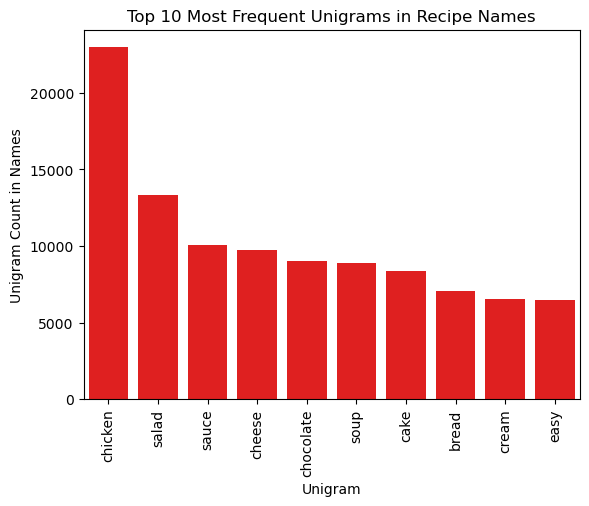

In [8]:
# top 10 most common unigrams 
unigram_counts = all_unigrams_in_names.value_counts()
top_ten_name_unigrams = unigram_counts.sort_values().nlargest(n = 10)

sns.barplot(top_ten_name_unigrams, color = 'red')
plt.xticks(rotation = 90)
plt.xlabel('Unigram')
plt.ylabel('Unigram Count in Names')
plt.title('Top 10 Most Frequent Unigrams in Recipe Names')

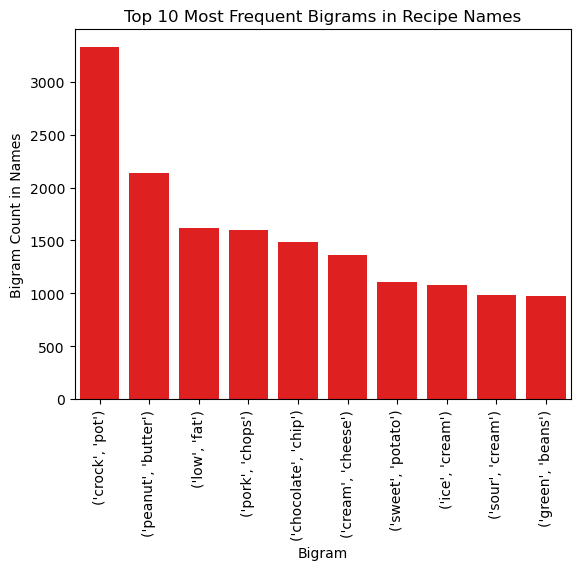

In [9]:
# analyze the most repeated words in name:
word_cleaner = lambda x: x.lower().strip()

# filter out all words present in the recipe names 
all_bigrams = []
for i in range(len(all_unigrams_in_names) - 1):
    all_bigrams.append((all_unigrams_in_names[i], all_unigrams_in_names[i + 1]))

all_bigrams = pd.Series(all_bigrams)

# top 10 most common bigrams
bigram_counts = all_bigrams.value_counts()
top_ten_name_bigrams = bigram_counts.nlargest(n = 10)  # already sorted descending


sns.barplot(x = top_ten_name_bigrams.index.astype(str), y = top_ten_name_bigrams.values, color = 'red')
plt.xticks(rotation=90)
plt.xlabel('Bigram')
plt.ylabel('Bigram Count in Names')
plt.title('Top 10 Most Frequent Bigrams in Recipe Names')
plt.show()

- #### Analyzing Tags

Text(0.5, 1.0, 'Top 10 Most Frequent Tags')

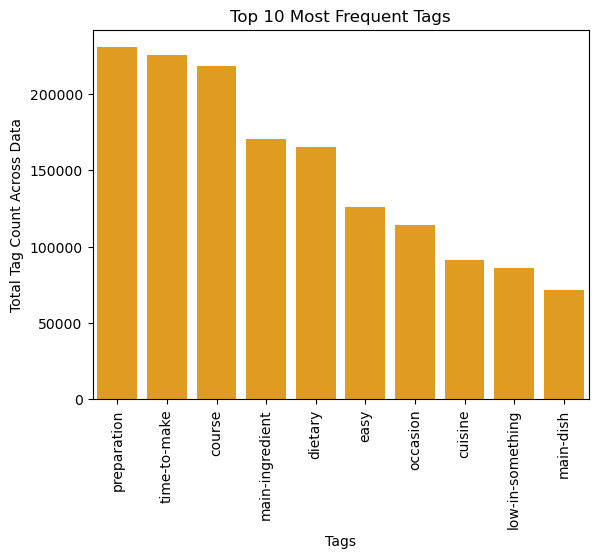

In [10]:
# analyze the most repeated words in name:
tag_cleaner = lambda x: x.replace('\'', '').replace('[', '').replace(']', '').replace(',', '')

cleaned_tags = all_recipes_raw['tags'].apply(tag_cleaner)
final_tags = pd.Series([word for tag in cleaned_tags for word in tag.split()])

tag_counts = final_tags.value_counts()
top_ten_tags = tag_counts.sort_values().nlargest(n = 10)

sns.barplot(top_ten_tags, color = 'orange')
plt.xticks(rotation = 90)
plt.xlabel('Tags')
plt.ylabel('Total Tag Count Across Data')
plt.title('Top 10 Most Frequent Tags')

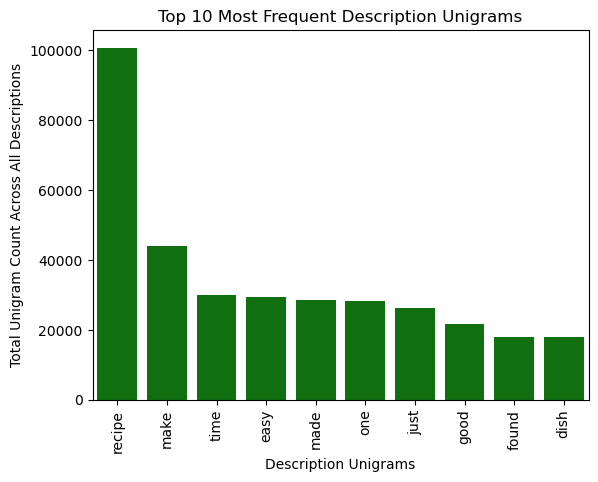

In [11]:
# analyze the most repeated words in name:
steps_cleaner = lambda x: str(x).replace('\'', '').replace('[', '').replace(']', '').replace(',', '')

cleaned_descriptions = all_recipes_raw['description'].apply(steps_cleaner)
cleaned_descriptions_unigrams = pd.Series([word for step in cleaned_descriptions for word in step.split() if word not in stop_words])

description_counts = cleaned_descriptions_unigrams.value_counts()
top_ten_description_words = description_counts.sort_values().nlargest(n = 10)

sns.barplot(top_ten_description_words, color = 'green')
plt.xticks(rotation = 90)
plt.xlabel('Description Unigrams')
plt.ylabel('Total Unigram Count Across All Descriptions')
plt.title('Top 10 Most Frequent Description Unigrams')
plt.show()

- #### Analysis of Ingredients

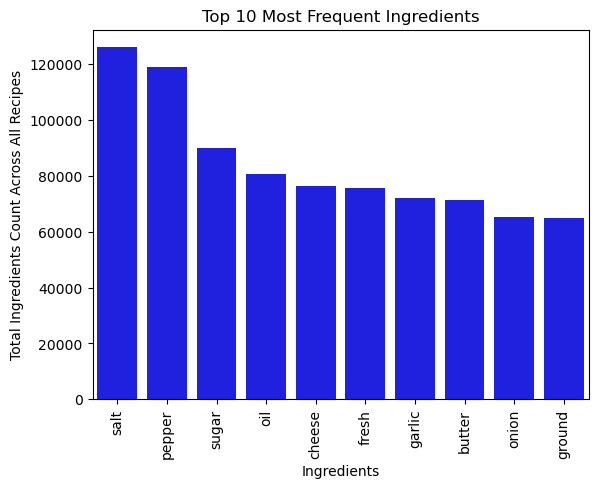

In [12]:
# analyze the most repeated words in name:
steps_cleaner = lambda x: str(x).replace('\'', '').replace('[', '').replace(']', '').replace(',', '')

cleaned_ingredients = all_recipes_raw['ingredients'].apply(steps_cleaner)
cleaned_descriptions_ingredients = pd.Series([word for step in cleaned_ingredients for word in step.split() if word not in stop_words])

ingredients_counts = cleaned_descriptions_ingredients.value_counts()
top_ten_ingredients = ingredients_counts.sort_values().nlargest(n = 10)

sns.barplot(top_ten_ingredients, color = 'blue')
plt.xticks(rotation = 90)
plt.xlabel('Ingredients')
plt.ylabel('Total Ingredients Count Across All Recipes')
plt.title('Top 10 Most Frequent Ingredients')
plt.show()

### Bivariate Analysis

The relationship between n_steps and n_ingredients may valuable to consider if the user is on a budget, has lack of experience in cooking, etc.


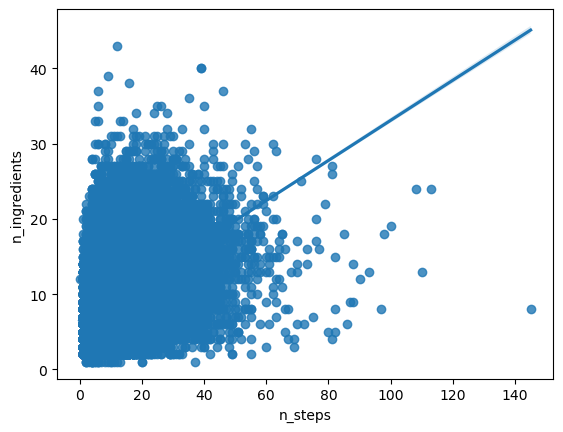

In [13]:
# plot ingredients against steps
sns.regplot(x = all_recipes_raw['n_steps'], y = all_recipes_raw['n_ingredients'])
plt.show()

### Multivariate Analysis

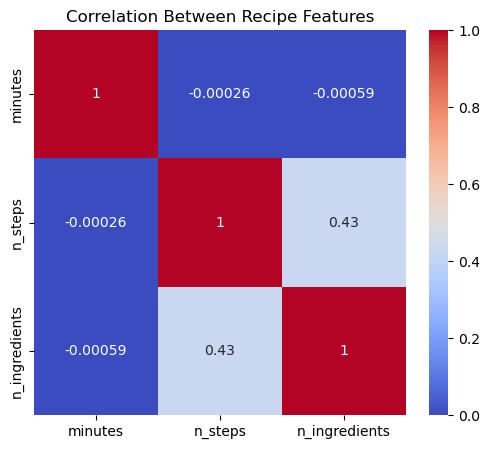

In [14]:
# select numeric columns only
numeric_features = all_recipes_raw[['minutes', 'n_steps', 'n_ingredients']]

# create correlation matrix
plt.figure(figsize=(6,5))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm')

plt.title("Correlation Between Recipe Features")
plt.show()

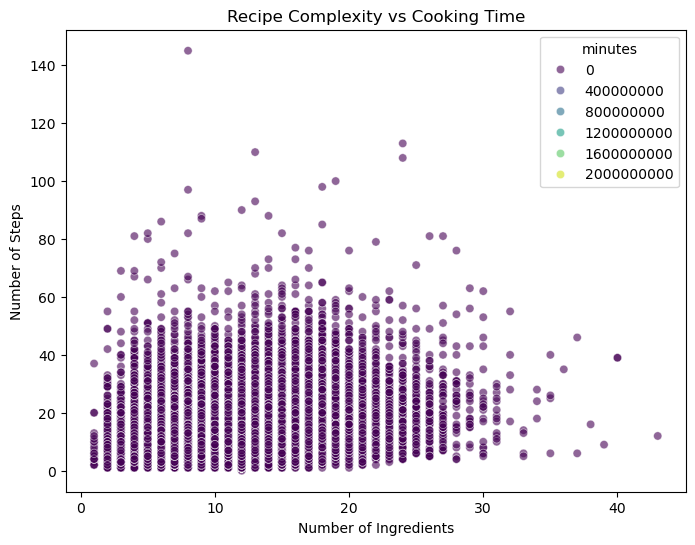

In [15]:
plt.figure(figsize=(8,6))

# plot ingredients and steps, stratified by duration
sns.scatterplot(
    x=all_recipes_raw['n_ingredients'],
    y=all_recipes_raw['n_steps'],
    hue=all_recipes_raw['minutes'],
    palette='viridis',
    alpha=0.6
)

plt.xlabel("Number of Ingredients")
plt.ylabel("Number of Steps")
plt.title("Recipe Complexity vs Cooking Time")
plt.show()

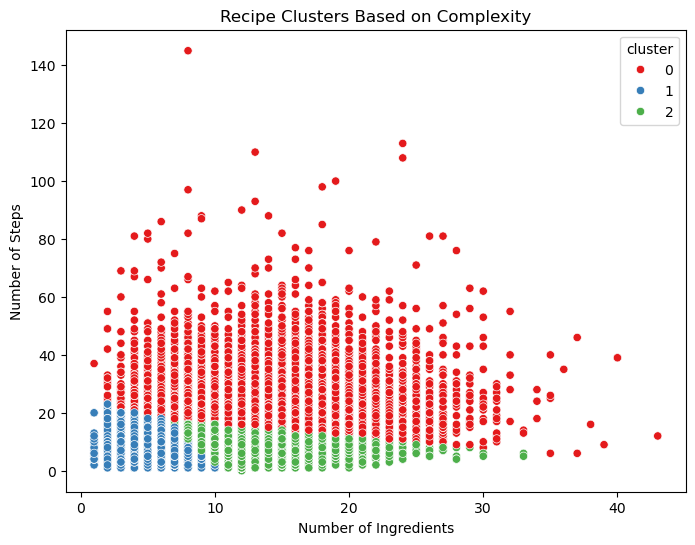

In [16]:
features = all_recipes_raw[['minutes','n_steps','n_ingredients']].dropna()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# cluster recipes based on ingredients and steps
kmeans = KMeans(n_clusters=3, random_state=42)
features['cluster'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=features,
    x='n_ingredients',
    y='n_steps',
    hue='cluster',
    palette='Set1'
)

plt.xlabel("Number of Ingredients")
plt.ylabel("Number of Steps")
plt.title("Recipe Clusters Based on Complexity")
plt.show()

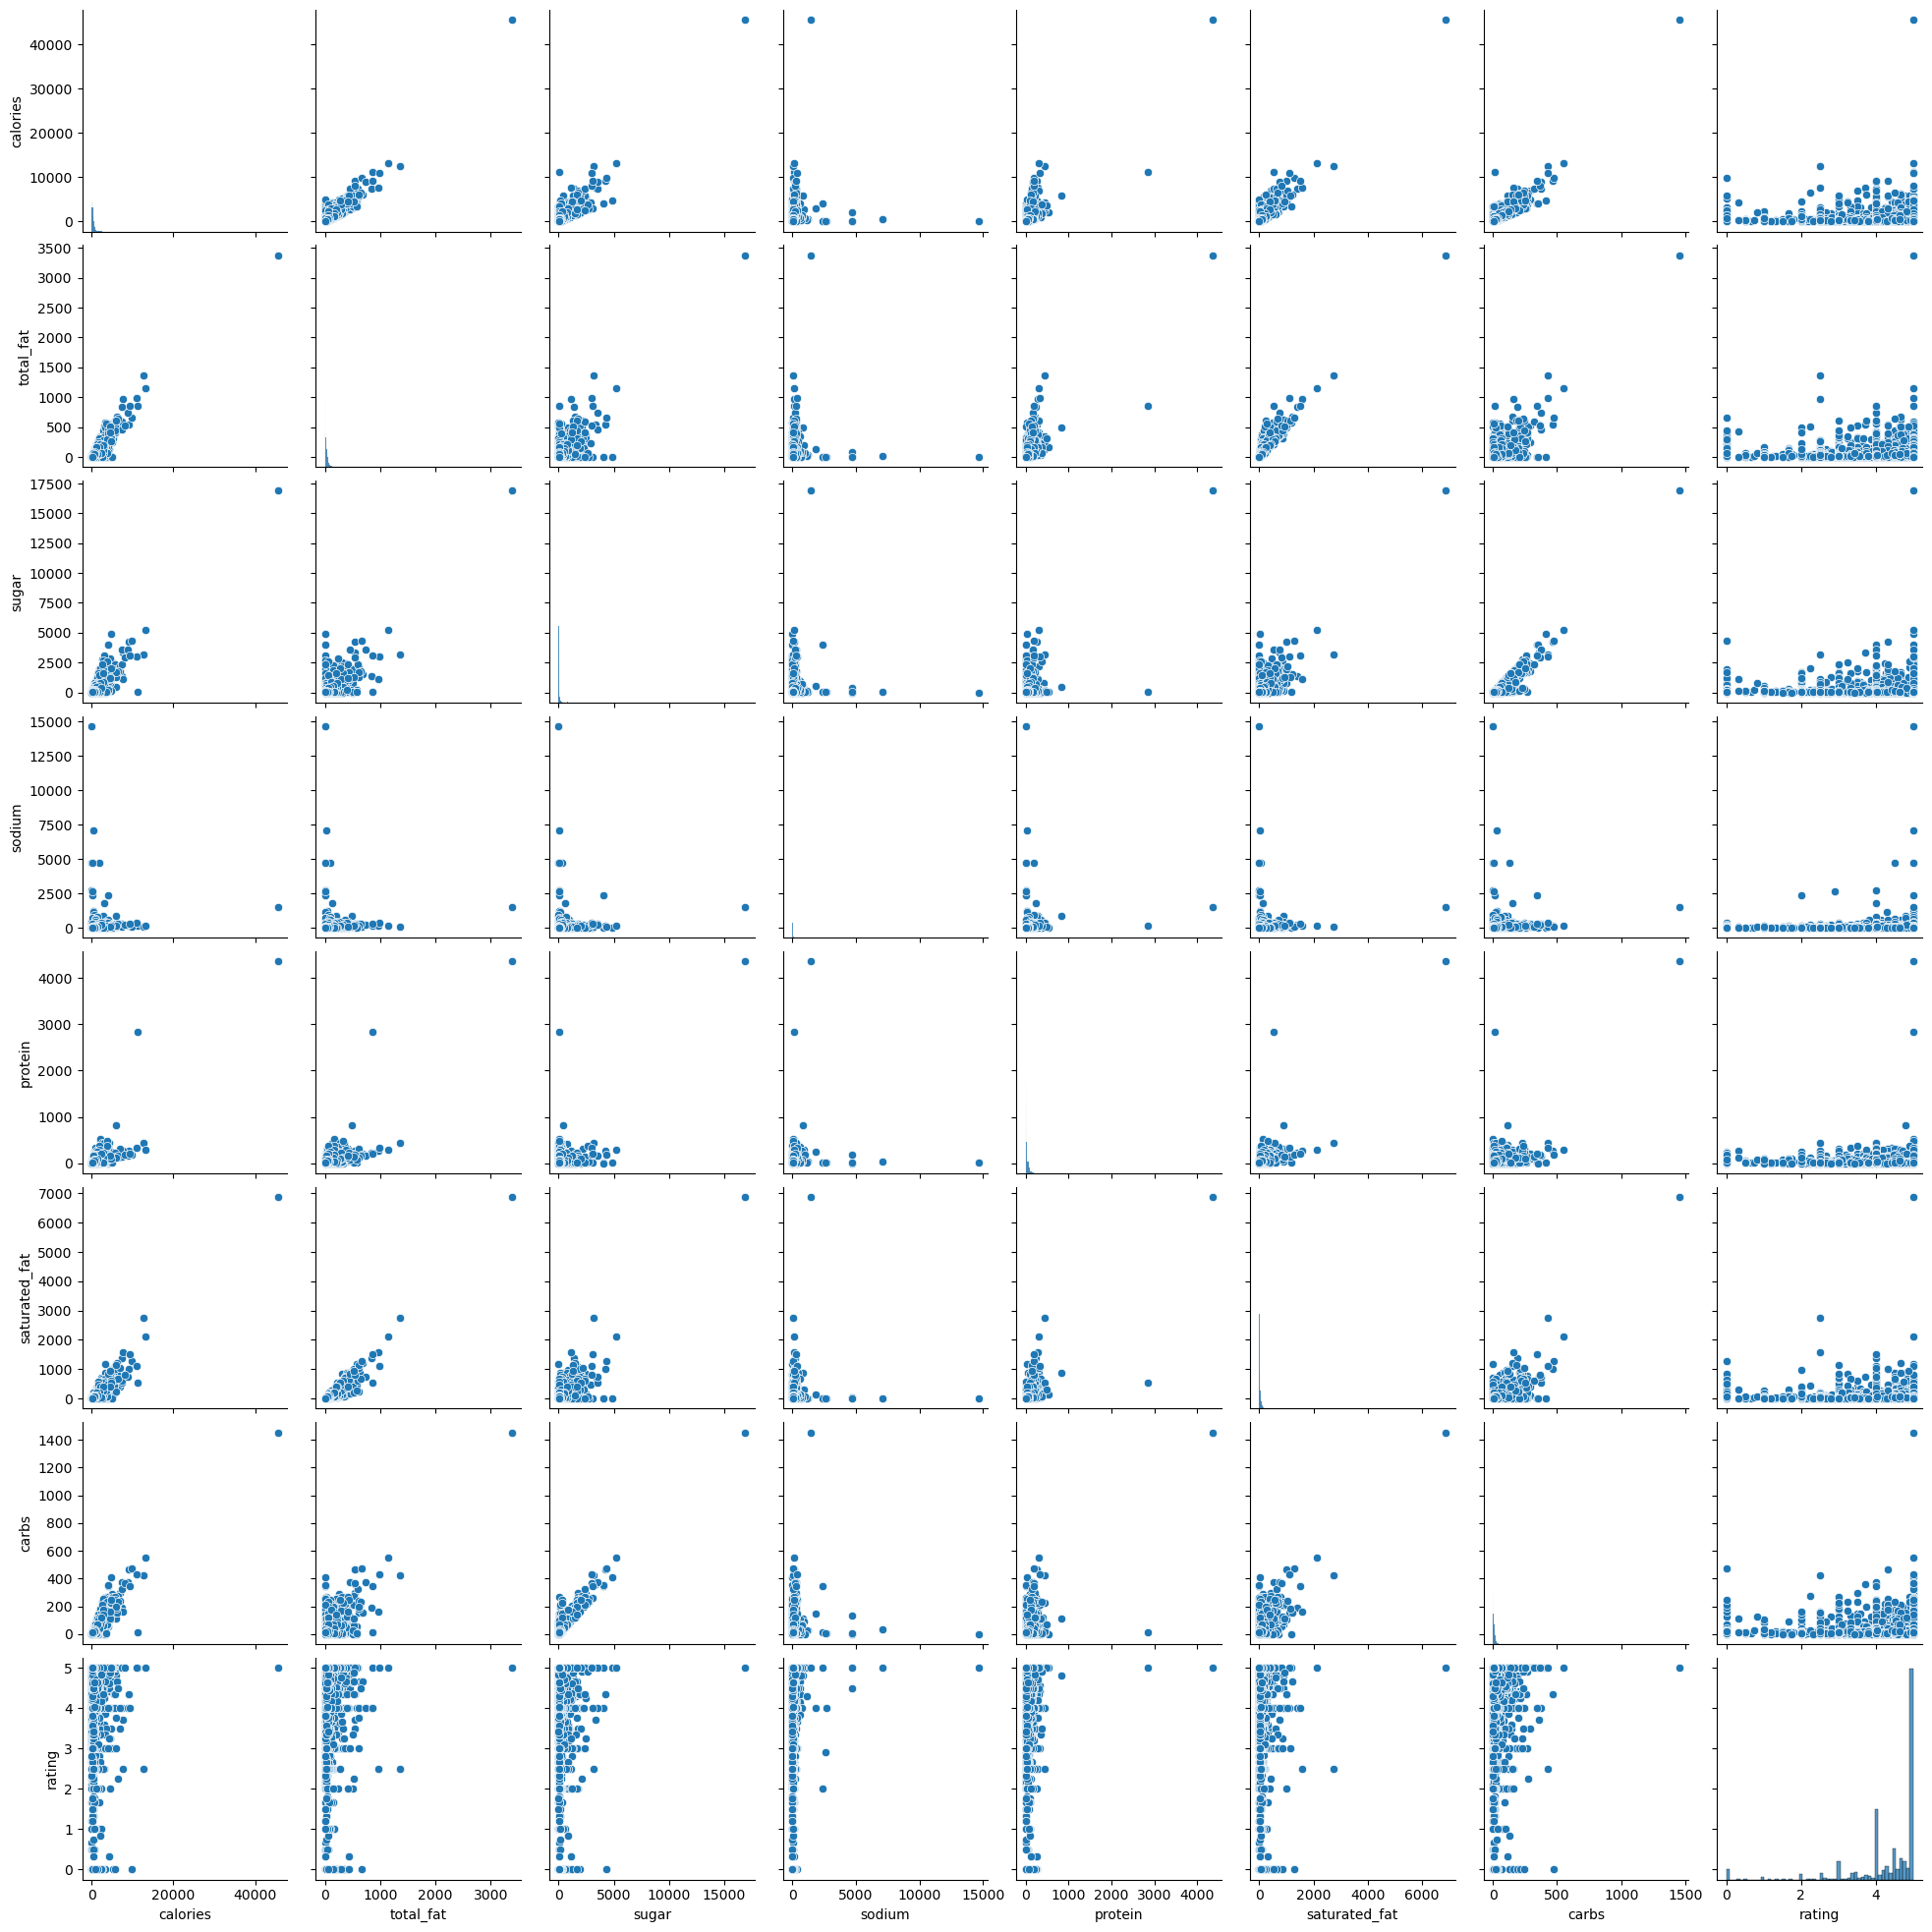

In [17]:
ratings_df = all_interactions_raw[['recipe_id', 'rating']]
avg_ratings_df = ratings_df.groupby('recipe_id').mean()

data = pd.DataFrame({'recipe_id': all_recipes_raw['id']})

# extract nutrition values
nutrition = all_recipes_raw["nutrition"].str.strip("[]").str.split(",", expand=True).astype(float)
nutrition.columns = ["calories","total_fat","sugar","sodium","protein","saturated_fat","carbs"]
data = pd.concat([data, nutrition], axis=1)

merged = data.merge(avg_ratings_df, on='recipe_id', how='inner')

sample = merged.sample(10000)

# plot correlation matrix 
pairplt = sns.pairplot(sample.drop(columns=['recipe_id']))

---
### **Modeling**

- #### Baseline(s)
#### To establish a baseline level of accuracy, we implemented two simple models - one that predicts global rating mean and one that predicts user-specific rating mean (with recipe-specific and global mean as fallbacks)

In [18]:
# set-up
Xtrain, Xtest, ytrain, ytest =  train_test_split(
    all_interactions_raw[['user_id', 'recipe_id']], 
    all_interactions_raw['rating'],
    test_size=0.15,
    random_state=67)

def testModel(true, predicted):
    return root_mean_squared_error(true, predicted)

- Baseline #1 - Global Mean

In [19]:
# train model
def get_global_mean(ratings):
    return np.mean(ratings)

def baseline_1(global_mean):
    return global_mean

# test model
global_mean = get_global_mean(ytrain)
b1_ypreds = [baseline_1(global_mean) for _ in range(len(Xtest))]

b1_rmse = testModel(ytest, b1_ypreds)
print(f'Baseline Model 1 Accuracy (RMSE): {b1_rmse}')

Baseline Model 1 Accuracy (RMSE): 1.2691731414611411


- Baseline #2 - User/Recipe Mean

In [20]:
# helper data structures
def get_user_average(ids, ratings):
    interactions = pd.concat([ids['user_id'], ratings], axis=1)
    by_user = interactions.groupby('user_id')['rating'].mean()
    return by_user

def get_recipe_average(ids, ratings):
    interactions = pd.concat([ids['recipe_id'], ratings], axis=1)
    by_recipe = interactions.groupby('recipe_id')['rating'].mean()
    return by_recipe

In [21]:
# train model
def baseline_2(user_id, recipe_id, user_averages, recipe_averages, global_mean):
    try:
        pred = user_averages.loc[user_id]
    except KeyError:
        try:
            pred = recipe_averages.loc[recipe_id]
        except KeyError:
            pred = global_mean
    
    return pred

# test model
user_averages = get_user_average(Xtrain, ytrain)
recipe_averages = get_recipe_average(Xtrain, ytrain)

b2_ypreds = [baseline_2(u, r, user_averages, recipe_averages, global_mean) for u, r in zip(Xtest['user_id'], Xtest['recipe_id'])]

b2_rmse = testModel(ytest, b2_ypreds)
print(f'Baseline Model 2 Accuracy (RMSE): {b2_rmse}')

Baseline Model 2 Accuracy (RMSE): 1.2607318852947456


- #### k-Nearest Neighbors

In [22]:
# load data
recipes = pd.read_csv("data/RAW_recipes.csv")
ratings = pd.read_csv("data/RAW_interactions.csv")[["user_id","recipe_id","rating"]]

# merge features into interactions
df = ratings.merge(recipes, left_on="recipe_id", right_on="id", how="inner")

# parse nutrition
nutrition = df["nutrition"].str.strip("[]").str.split(",", expand=True).astype(float)
nutrition.columns = ["calories","total_fat","sugar","sodium","protein","saturated_fat","carbs"]
df = pd.concat([df, nutrition], axis=1)

# feature matrix X
X = df[[
    "minutes",
    "n_steps",
    "n_ingredients",
    "calories",
    "total_fat",
    "sugar",
    "sodium",
    "protein",
    "saturated_fat",
    "carbs"
]]

# target
y = df["rating"]

# split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = Pipeline([
    ("scale", StandardScaler()),
    ("knn", KNeighborsRegressor(
        n_neighbors=25,
        weights="distance",
        p=2  # euclidean distance
    ))
])

model.fit(Xtrain, ytrain)
preds = model.predict(Xtest)

rmse = np.sqrt(mean_squared_error(ytest, preds))
print("KNN Regressor Accuracy (RMSE):", rmse)

KNN Regressor Accuracy (RMSE): 1.3563122551054256


- #### Matrix Factorization

In [23]:
df = pd.read_csv("data/RAW_interactions.csv")
df = df[['user_id', 'recipe_id', 'rating']].dropna()

# make a train/validation split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# map users & items
users = train_df['user_id'].unique()
recipes = train_df['recipe_id'].unique()

user2idx = {u:i for i, u in enumerate(users)}
item2idx = {r:i for i, r in enumerate(recipes)}

train_df = train_df[train_df['user_id'].isin(users) & train_df['recipe_id'].isin(recipes)]
test_df = test_df[test_df['user_id'].isin(users) & test_df['recipe_id'].isin(recipes)]

train_df['u_idx'] = train_df['user_id'].map(user2idx)
train_df['i_idx'] = train_df['recipe_id'].map(item2idx)
test_df['u_idx'] = test_df['user_id'].map(user2idx)
test_df['i_idx'] = test_df['recipe_id'].map(item2idx)

test_df = test_df.dropna()
test_df['u_idx'] = test_df['u_idx'].astype(int)
test_df['i_idx'] = test_df['i_idx'].astype(int)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

# initialize model
K = 32
alpha = 0.005
lam = 0.02
epochs = 10

mu = train_df['rating'].mean()
n_users = len(users)
n_items = len(recipes)

P = np.random.normal(0, 0.1, (n_users, K))
Q = np.random.normal(0, 0.1, (n_items, K))
bu = np.zeros(n_users)
bi = np.zeros(n_items)

# train model
for epoch in range(epochs):
    train_sample = train_df.sample(40000)   # speed

    for row in train_sample.itertuples():
        u = row.u_idx
        i = row.i_idx
        r = row.rating
        
        pred = mu + bu[u] + bi[i] + np.dot(P[u], Q[i])
        err = r - pred

        bu[u] += alpha * (err - lam * bu[u])
        bi[i] += alpha * (err - lam * bi[i])
        P[u] += alpha * (err * Q[i] - lam * P[u])
        Q[i] += alpha * (err * P[u] - lam * Q[i])

    # evaluate
    preds = []
    for row in test_df.sample(10000).itertuples():
        u = row.u_idx
        i = row.i_idx
        p = mu + bu[u] + bi[i] + np.dot(P[u], Q[i])
        preds.append(p)

    rmse = root_mean_squared_error(test_df.sample(10000)['rating'], preds)
    print(f"Epoch {epoch+1}: RMSE = {rmse:.4f}")

print('Final Matrix Factorization Accuracy (RMSE):', rmse)


Train size: 905893
Test size: 171004
Epoch 1: RMSE = 1.0758
Epoch 2: RMSE = 1.0682
Epoch 3: RMSE = 1.0896
Epoch 4: RMSE = 1.0721
Epoch 5: RMSE = 1.0647
Epoch 6: RMSE = 1.0603
Epoch 7: RMSE = 1.0819
Epoch 8: RMSE = 1.0701
Epoch 9: RMSE = 1.0753
Epoch 10: RMSE = 1.0755
Final Matrix Factorization Accuracy (RMSE): 1.0754578498520657


- #### Markov Chains

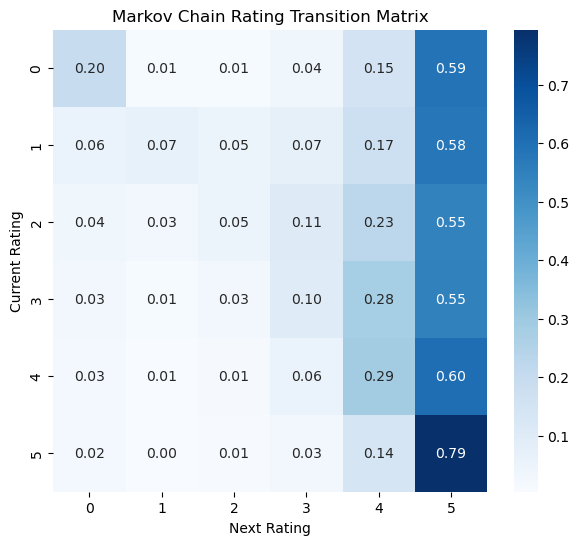

Markov Chain Accuracy (RMSE): 1.0079710994801558


In [24]:
# load data
inter = pd.read_csv("data/RAW_interactions.csv")

# sort interactions chronologically per user (if no date, use order in file)
if "date" in inter.columns:
    inter = inter.sort_values(["user_id", "date"])
else:
    inter = inter.sort_values(["user_id"])

# keep only needed columns
inter = inter[["user_id", "recipe_id", "rating"]]

# build transition matrix
# matrix for ratings 0–5
T = np.zeros((6, 6))

for uid, group in inter.groupby("user_id"):
    ratings = group["rating"].tolist()

    # build transitions per user
    for r1, r2 in zip(ratings[:-1], ratings[1:]):
        T[int(r1)][int(r2)] += 1

# convert counts to probabilities
row_sums = T.sum(axis=1)
P = np.divide(
    T,
    row_sums[:, None], 
    out=np.zeros_like(T),
    where=row_sums[:, None] != 0
)

#print('Markov Transition Matrix:')
#print(pd.DataFrame(P, index=range(6), columns=range(6)))

# make predictions
def markov_predict(prev_rating):
    """Predict expected next rating using transition probabilities."""
    dist = P[int(prev_rating)]
    expected_value = np.dot(dist, np.arange(6))  # Weighted sum = EV
    return expected_value

y_true, y_pred = [], []

for uid, group in inter.groupby("user_id"):
    ratings = group["rating"].tolist()
    
    if len(ratings) < 2:
        continue
    
    for r1, r2 in zip(ratings[:-1], ratings[1:]):
        y_true.append(r2)
        y_pred.append(markov_predict(r1))

# test model
rmse_markov = root_mean_squared_error(y_true, y_pred)

# plot transition matrix
plt.figure(figsize=(7,6))
sns.heatmap(P, annot=True, cmap="Blues", fmt=".2f")
plt.title("Markov Chain Rating Transition Matrix")
plt.xlabel("Next Rating")
plt.ylabel("Current Rating")
plt.show()

print("Markov Chain Accuracy (RMSE):", rmse_markov)

- #### LightGBM

In [25]:
# Create LightGBM Dataset
train_data = lgb.Dataset(Xtrain, label=ytrain)
test_data = lgb.Dataset(Xtest, label=ytest)

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "num_leaves": 64,
    "learning_rate": 0.04,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.85,
    "bagging_freq": 5,
    "min_data_in_leaf": 50,
    "lambda_l2": 1.0,
    "verbosity": -1
}

# train model
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=50)
]

model_lgb = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=2000,
    callbacks=callbacks
)

# test model
preds = model_lgb.predict(Xtest)
rmse = root_mean_squared_error(ytest, preds)

print("LightGBM Accuracy (RMSE):", rmse)


Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 1.26838
[100]	valid_0's rmse: 1.26711
[150]	valid_0's rmse: 1.26647
[200]	valid_0's rmse: 1.26588
[250]	valid_0's rmse: 1.26538
[300]	valid_0's rmse: 1.265
[350]	valid_0's rmse: 1.26473
[400]	valid_0's rmse: 1.26442
[450]	valid_0's rmse: 1.26415
[500]	valid_0's rmse: 1.26386
[550]	valid_0's rmse: 1.26365
[600]	valid_0's rmse: 1.26336
[650]	valid_0's rmse: 1.26318
[700]	valid_0's rmse: 1.263
[750]	valid_0's rmse: 1.26277
[800]	valid_0's rmse: 1.26263
[850]	valid_0's rmse: 1.26243
[900]	valid_0's rmse: 1.26223
[950]	valid_0's rmse: 1.26212
[1000]	valid_0's rmse: 1.26197
[1050]	valid_0's rmse: 1.26189
[1100]	valid_0's rmse: 1.26176
[1150]	valid_0's rmse: 1.2616
[1200]	valid_0's rmse: 1.26155
[1250]	valid_0's rmse: 1.26148
[1300]	valid_0's rmse: 1.26144
[1350]	valid_0's rmse: 1.26138
[1400]	valid_0's rmse: 1.26129
[1450]	valid_0's rmse: 1.26127
[1500]	valid_0's rmse: 1.26122
[1550]	valid_0's rmse: 1.26116
[16

- #### XGBoost

In [ ]:
# load data
interactions = pd.read_csv("data/RAW_interactions.csv")
recipes = pd.read_csv("data/RAW_recipes.csv")

# group by recipe to get average rating
popularity = interactions.groupby("recipe_id").agg(
    avg_rating=("rating", "mean"),
    rating_count=("rating", "count")
).reset_index()

# merge average ratings with recipes
data = recipes.merge(popularity, left_on="id", right_on="recipe_id", how="left")

cols = [
    "id", "minutes", "n_steps", "n_ingredients",
    "avg_rating", "rating_count", "nutrition"
]

data = data[cols].dropna()

# extract nutrition values
nutrition = data['nutrition'].apply(eval).to_list()
data[['calories','fat','sugar','sodium','protein','sat_fat','carbs']] = pd.DataFrame(nutrition)
data = data.drop(columns=["nutrition", "id"])

# set-up
X = data.drop(columns=["avg_rating"])
y = data["avg_rating"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# intialize model
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.8,
    random_state=42
)

# train model
model.fit(X_train, y_train)

# test model
preds = model.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)


print("XGBoost RMSE:", rmse)

XGBoost RMSE: 0.9850038591724777


---
### **Evaluation**

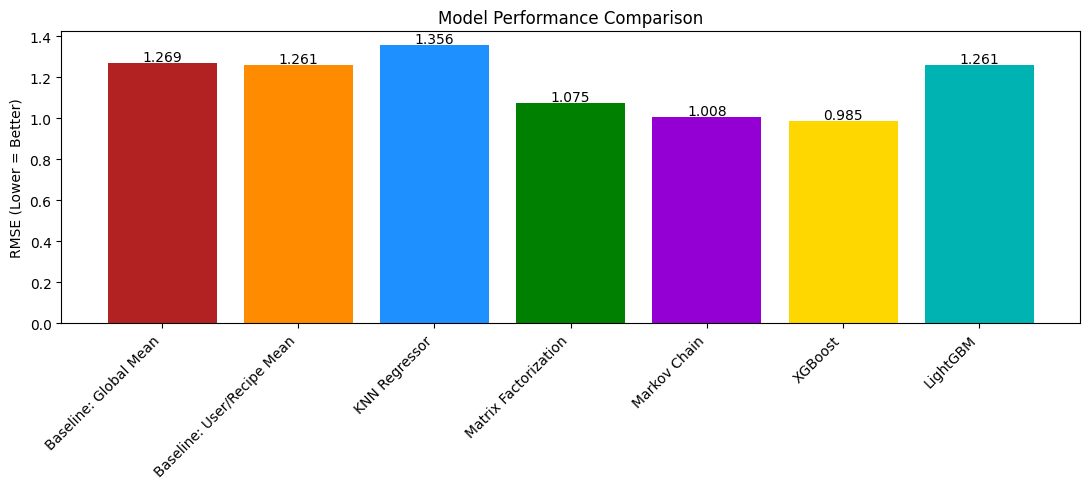

=== Evaluation Summary Table ===


,Model,RMSE,Improvement % vs Baseline
0,Baseline: Global Mean,1.269,0.00
1,Baseline: User/Recipe Mean,1.261,0.63
2,KNN Regressor,1.356,-6.86
3,Matrix Factorization,1.075,15.29
4,Markov Chain,1.008,20.57
5,XGBoost,0.985,22.38
6,LightGBM,1.261,0.63


Best Model: XGBoost
RMSE: 0.985


In [ ]:
rmse_scores = {
    "Baseline: Global Mean": 1.269,
    "Baseline: User/Recipe Mean": 1.261,
    "KNN Regressor": 1.356,
    "Matrix Factorization": 1.075,
    "Markov Chain": 1.008,
    "XGBoost": 0.985,
    "LightGBM": 1.261
}

# performance improvement calculation
baseline = rmse_scores["Baseline: Global Mean"]

improvement = {
    model: (baseline - score) / baseline * 100
    for model, score in rmse_scores.items()
}

evaluation_table = pd.DataFrame({
    "Model": list(rmse_scores.keys()),
    "RMSE": list(rmse_scores.values()),
    "Improvement % vs Baseline": [round(improvement[m], 2) for m in rmse_scores.keys()]
})

# plot barchart
colors = [
    "#b22222", "#ff8c00", "#1e90ff",
    "#008000", "#9400d3", "#ffd700",
    "#00b3b3"
]

plt.figure(figsize=(11, 5))
plt.bar(evaluation_table["Model"], evaluation_table["RMSE"], color=colors)

plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE (Lower = Better)")
plt.title("Model Performance Comparison")

# Label each bar
for index, value in enumerate(evaluation_table["RMSE"]):
    plt.text(index, value + 0.01, f"{value:.3f}", ha='center')

plt.tight_layout()
plt.show()

# summary table
print("=== Evaluation Summary Table ===")
display(evaluation_table)

# best model
best_model = evaluation_table.loc[evaluation_table["RMSE"].idxmin()]
print("Best Model:", best_model["Model"])
print("RMSE:", best_model["RMSE"])


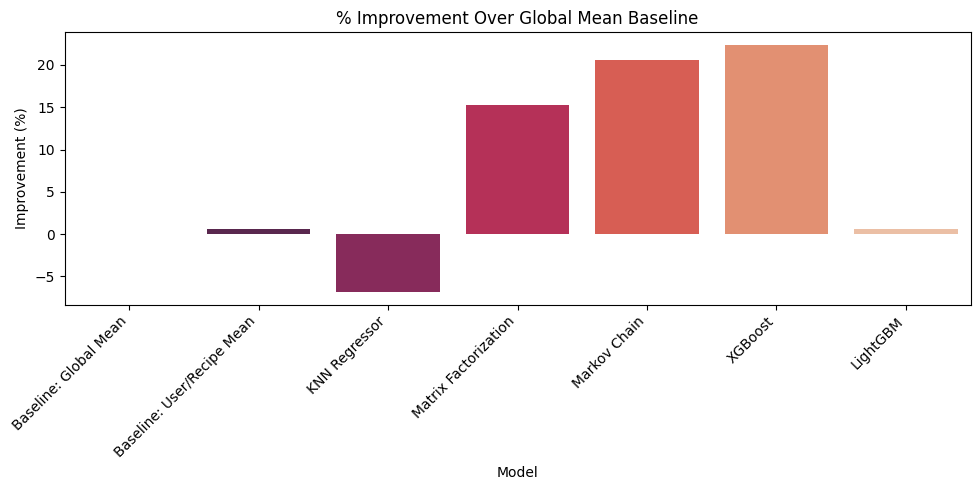

In [ ]:
# convert to DataFrame
improvement_df = pd.DataFrame({
    "Model": list(improvement.keys()),
    "Improvement % vs Baseline": [round(v, 2) for v in improvement.values()]
})

# plot improvement % vs baseline
plt.figure(figsize=(10,5))
sns.barplot(
    x="Model",
    y="Improvement % vs Baseline",
    data=improvement_df,
    palette="rocket"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Improvement (%)")
plt.title("% Improvement Over Global Mean Baseline")
plt.tight_layout()
plt.show()

---
### **Discussion**

**How has this dataset (or similar datasets) been used before?**  

Large-scale recipe datasets (e.g., Food.com, Recipe1M, Allrecipes) have been used for many tasks including recipe recommendation, ingredient-based retrieval, cross-modal recipe–image learning, and personalization recipe recommendation. The Food.com dataset has primarily been used for analyzing user–recipe interactions and building personalized recipe recommenders. Prior work uses the Food.com data to model user taste preferences, extract ingredient/flavor patterns, and build personalized recommenders using collaborative filtering.<a name="cite_ref-1"></a>[<sup>1</sup>](#cite_note-1)  
In the context of rating prediction, researchers typically treat user–recipe interactions as explicit feedback and evaluate models on prediction accuracy (RMSE).

**How has prior work approached the same (or similar) tasks?**  

This task has been studied extensively and has been approached using a variety of methods. Early papers relied on neighborhood-based collaborative filtering techniques such as user- and item-kNN to serve as baseline models.<a name="cite_ref-2"></a>[<sup>2</sup>](#cite_note-2) Collaborative filtering and matrix factorization approaches—including latent factor models and bias terms—greatly improved performance and now serve as foundational recommendation models.<a name="cite_ref-3"></a>[<sup>3</sup>](#cite_note-3)  
More recent work has explored sequence-aware models such as Markov chains to capture temporal dynamics in user behavior.<a name="cite_ref-4"></a>[<sup>4</sup>](#cite_note-4) Feature-based supervised learning methods like XGBoost and LightGBM have become common when rich metadata is available, often outperforming collaborative-only models.<a name="cite_ref-5"></a>[<sup>5, </sup>](#cite_note-5)<a name="cite_ref-6"></a>[<sup>6</sup>](#cite_note-6) Neural approaches—including neural collaborative filtering and transformer-based sequential models—are now widely used for large-scale multimodal recommendation tasks.<a name="cite_ref-7"></a>[<sup>7, </sup>](#cite_note-7)<a name="cite_ref-8"></a>[<sup>8</sup>](#cite_note-8)

**How do your results match or differ from what has been reported in related work?**  

Our evaluation follows expected trends: naive baselines have higher RMSE, latent-factor methods improve accuracy, and feature-rich gradient-boosted models perform best in our runs (XGBoost: ~0.985 RMSE vs global-mean baseline: ~1.269). This pattern aligns with findings in applied recommendation research, where content features and boosting methods often outperform simple collaborative-only models on item-level rating prediction.

---

### **References**

1. <a name="cite_note-1"></a> [^](#cite_ref-1) Majumder, S., McAuley, J., & Caverlee, J. (2019). *Food recommendations and recipe modeling.* https://doi.org/10.1145/3308558.3313703  
2. <a name="cite_note-2"></a> [^](#cite_ref-2) Herlocker, J. L., Konstan, J. A., Borchers, A., & Riedl, J. (1999). *An algorithmic framework for performing collaborative filtering.* https://doi.org/10.1145/312624.312682  
3. <a name="cite_note-3"></a> [^](#cite_ref-3) Koren, Y., Bell, R., & Volinsky, C. (2009). *Matrix factorization techniques for recommender systems.* https://doi.org/10.1109/MCI.2009.307287  
4. <a name="cite_note-4"></a> [^](#cite_ref-4) Rendle, S., Freudenthaler, C., & Schmidt-Thieme, L. (2010). *Factorizing personalized Markov chains for next-basket recommendation.* https://doi.org/10.1145/1772690.1772773  
5. <a name="cite_note-5"></a> [^](#cite_ref-5) Chen, T., & Guestrin, C. (2016). *XGBoost: A scalable tree boosting system.* https://doi.org/10.1145/2939672.2939785  
6. <a name="cite_note-6"></a> [^](#cite_ref-6) Ke, G. et al. (2017). *LightGBM: A highly efficient gradient boosting decision tree.* https://papers.nips.cc/paper_files/paper/2017/hash/6449f44a102fde848669bdd9eb6b76fa-Abstract.html  
7. <a name="cite_note-7"></a> [^](#cite_ref-7) He, X., Liao, L., Zhang, H., Nie, L., Hu, X., & Chua, T.-S. (2017). *Neural collaborative filtering.* https://doi.org/10.1145/3038912.3052569  
8. <a name="cite_note-8"></a> [^](#cite_ref-8) Kang, W.-C., & McAuley, J. (2018). *Self-attentive sequential recommendation.* https://doi.org/10.48550/arXiv.1808.09781
